# Train a model

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from os.path import join, basename, isfile
import os
import shutil

import pandas as pd
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import seaborn as sns

from biomass.dataset import BiomassDataset, BiomassBandNormalize
from biomass.models import (
    TemporalPixelRegressionLightning, S1MeanWrapper, 
    LinearPixelRegression, avg_rmse)

In [5]:
root_dir = '/Users/lewfish/data/biomass/'
dataset_dir = join(root_dir, 'dataset')
output_dir = join(root_dir, 'output')
lightning_dir = join(output_dir, 'lightning')
os.makedirs(lightning_dir, exist_ok=True)

In [6]:
# Use a small sample for testing. Assumes this was downloaded by the 
# explore_data.ipynb notebook
chip_ids = ['d8e45923', 'a4529dfd', 'fa341f98', 'b27bcdad', '284543b9',
            '329f5682', '52b1d478', 'a7cf91c5', '174ca2b3', '25a25054']

def train_val_split(sample_ids, train_ratio):
    train_sz = round(train_ratio * len(sample_ids))
    return sample_ids[0:train_sz], sample_ids[train_sz:]

train_ratio = 0.6
train_chip_ids, val_chip_ids = train_val_split(chip_ids, train_ratio)
train_ds = BiomassDataset(
    dataset_dir, 'train', train_chip_ids, transform=BiomassBandNormalize())
# split is 'train' because there is only a train and test split in this dataset, and 
# we are using a portion of the train split for validation.
val_ds = BiomassDataset(
    dataset_dir, 'train', val_chip_ids, transform=BiomassBandNormalize())

batch_size = 2
num_workers = 0 
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

In [7]:
x, y, chip_metadata = train_ds[0]
print(x.shape)
print(y.shape)
print(chip_metadata.keys())

torch.Size([12, 15, 256, 256])
torch.Size([256, 256])
dict_keys(['chip_id', 'full_months', 'partial_months', 's1_masks', 's2_masks'])


/opt/homebrew/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [8]:
# Get a single batch.
for x, y, chip_metadata in train_dl:
    break

/opt/homebrew/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [9]:
model = TemporalPixelRegressionLightning(S1MeanWrapper(LinearPixelRegression(4, 1)))

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [10]:
z = model(x)
z.shape

torch.Size([2, 1, 256, 256])

In [11]:
avg_rmse(y, z)

tensor(107.3698, grad_fn=<MeanBackward0>)

In [12]:
shutil.rmtree(lightning_dir)
os.makedirs(lightning_dir, exist_ok=True)

lr = 1e-4
epochs = 2
fast_dev_run = False

csv_logger = CSVLogger(join(lightning_dir, 'csv-logs'))
trainer = pl.Trainer(
    min_epochs=1, max_epochs=epochs+1, logger=[csv_logger], fast_dev_run=fast_dev_run)

trainer.fit(model, train_dl, val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/lewfish/data/biomass/output/lightning/csv-logs/lightning_logs

  | Name  | Type          | Params | In sizes              | Out sizes       
-----------------------------------------------------------------------------------
0 | model | S1MeanWrapper | 5      | [1, 12, 15, 256, 256] | [1, 1, 256, 256]
-----------------------------------------------------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


A Jupyter Widget

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a l

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

`Trainer.fit` stopped: `max_epochs=3` reached.


## Load metrics saved in CSV file and plot

In [13]:
log_dir = join(lightning_dir, 'csv-logs', 'lightning_logs', 'version_0')
metrics_path = join(log_dir, 'metrics.csv')

metrics_df = pd.read_csv(metrics_path)
metrics_df

,validation_loss,epoch,step,train_loss
0,68.276657,0,2,NaN
1,NaN,0,2,94.477028
2,68.276031,1,5,NaN
3,NaN,1,5,92.013710
4,68.275414,2,8,NaN
5,NaN,2,8,92.232140


In [14]:
# This is to fix https://github.com/Lightning-AI/lightning/issues/11605
_metrics_df = metrics_df.groupby(by='epoch').mean().reindex(columns=['train_loss', 'validation_loss'])
_metrics_df

,train_loss,validation_loss
epoch,,
0,94.477028,68.276657
1,92.013710,68.276031
2,92.232140,68.275414


<AxesSubplot: xlabel='epoch'>

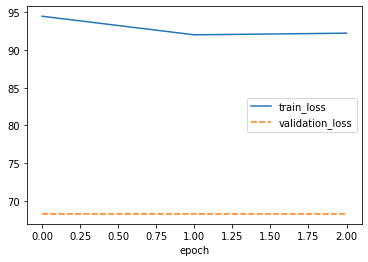

In [15]:
sns.lineplot(_metrics_df)

In [16]:
model_path = join(lightning_dir, 'model.ckpt')
trainer.save_checkpoint(model_path)

In [17]:
model = TemporalPixelRegressionLightning.load_from_checkpoint(
    model_path, model=S1MeanWrapper(LinearPixelRegression(4, 1)))
model.eval()
z = model(x)

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
